# Lab 4 – Introduction to RNNs with PyTorch

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`


**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.* [*Instructions for passing*]

 - For each task:
   - **Complete the code** where indicated.
   - **Upload the required results** from each task to **Homework 4 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:
   Submit your **entire completed notebook (including your code!)** to **Homework 4 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  
Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---




In this lab, we will explore **Recurrent Neural Networks (RNNs)** using **PyTorch**. This lab is hands-on and designed to be run during class time. Each step is followed by detailed explanations and code examples.





## Objectives
- Understand RNN architecture and its components


In the previous lab we learned about CNNs, now we move on to RNNs! Creating a RNN network is much simpler than creating CNN networks which require many different convolutional filters and kernels. You can create a working RNN network only with few lines. Here we will first look into different models on a simple synthetic data. After that we will investigate more by creating a model for sentimental analysis.


### Introduction and Imports




In [ ]:

# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
from torchsummary import summary
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


We move models and data to ```device``` (cuda if available) for GPU acceleration.


In [ ]:

# Setup device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


Here we generate 10,000 time series instances of length 51 and use 70% as a training set. We will put first 50 data points to the model to predict the last data point. Each sample is a noisy combination of sine waves + random noise.

Model goal is to predict the last time step given previous steps.

In [ ]:
# Function to generate synthetic time series data
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))   # Wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + Wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)    # + Noise
    return series[..., np.newaxis].astype(np.float32)


In [ ]:
# Set random seeds for reproducibility
np.random.seed(12345)
torch.manual_seed(12345)

# Generate dataset
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# Split into training and testing
X_train = series[:7000, :n_steps]
y_train = series[:7000, -1]
X_test = series[7000:, :n_steps]
y_test = series[7000:, -1]


*You* need to check the special axis at the end to indicate the sequential data.

In [ ]:
# Check shape
print("Training X shape:", X_train.shape)
print("Training y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test y shape:", y_test.shape)

Training X shape: (7000, 50, 1)
Training y shape: (7000, 1)
Test X shape: (3000, 50, 1)
Test y shape: (3000, 1)


Here you can check few examples of our synthetic time series. Our objective is to create a model to predict these blue Xs.

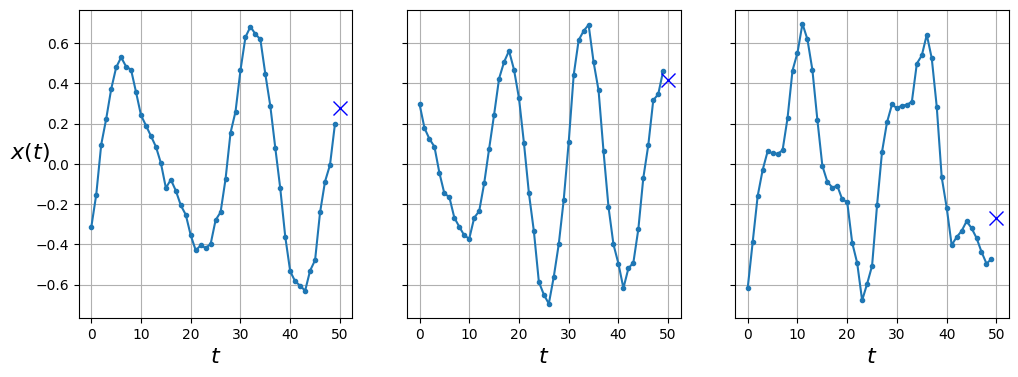

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_test[col, :, 0], y_test[col, 0], y_label=("$x(t)$" if col==0 else None))
plt.show()

We will create the following models on the same dataset:
 - Fully connected network
 - Simple RNN
 - Deep RNN
 - LSTM
 - GRU

### Fully connected network

Fully connected network can also handle sequential data by regarding each time point input independently.

In [ ]:
# Fully Connected Network (FCN) for time series forecasting

class FCN(nn.Module):
    def __init__(self, n_steps):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(n_steps, 1)  # Maps all time steps to a single output

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

# Instantiate the model
model_fcn = FCN(n_steps).to(device)


Why Flatten?
- Sequential inputs are treated as independent features — no memory of order.
- This makes FCNs fundamentally different from RNNs that remember sequence!




In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_fcn.parameters(), lr=0.001)


Loss:
- We use Mean Squared Error (MSE) because this is a regression task.

Optim:
- Adam optimizer is generally a good default for deep learning.


In [ ]:
# Move data to device
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)

# Training the model
n_epochs = 10
for epoch in range(n_epochs):
    model_fcn.train()
    optimizer.zero_grad()

    y_pred = model_fcn(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


Epoch 1/10, Loss: 0.200004
Epoch 2/10, Loss: 0.195103
Epoch 3/10, Loss: 0.190339
Epoch 4/10, Loss: 0.185713
Epoch 5/10, Loss: 0.181225
Epoch 6/10, Loss: 0.176878
Epoch 7/10, Loss: 0.172672
Epoch 8/10, Loss: 0.168607
Epoch 9/10, Loss: 0.164683
Epoch 10/10, Loss: 0.160898


Prediction:
- After .eval(), we disable gradients (torch.no_grad()) for efficiency.


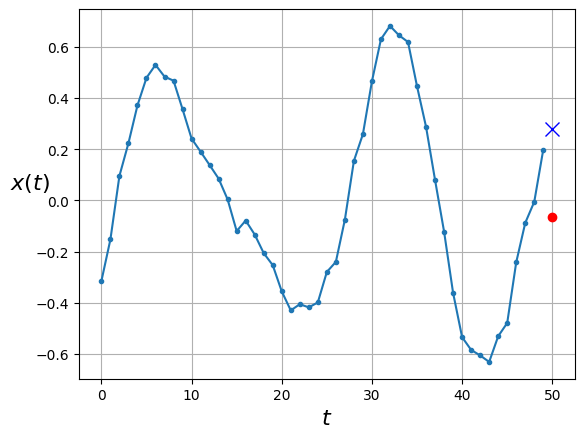

In [ ]:
# Move test data to device
X_test_tensor = torch.tensor(X_test, device=device)

# Evaluate
model_fcn.eval()
with torch.no_grad():
    y_test_pred = model_fcn(X_test_tensor)

# Move back to CPU for plotting
y_test_pred = y_test_pred.cpu().numpy()

# Plot first test sample prediction
plot_series(X_test[0, :, 0], y_test[0, 0], y_test_pred[0, 0])


### Simple RNN


In [ ]:
# Basic RNN model

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=1):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Final output layer

    def forward(self, x):
        out, _ = self.rnn(x)  # Ignore hidden state
        out = out[:, -1, :]   # Take the output at the last time step
        out = self.fc(out)
        return out

# Instantiate the model
model_rnn = SimpleRNNModel(input_size=1, hidden_size=1).to(device)


In [ ]:

summary(model_rnn, (50, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 1], [-1, 2, 1]]               0
            Linear-2                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.005)


In [ ]:
# Reshape X to (batch_size, time_steps, features)
X_train_tensor = torch.tensor(X_train, device=device)  # already loaded earlier
y_train_tensor = torch.tensor(y_train, device=device)

n_epochs = 30
for epoch in range(n_epochs):
    model_rnn.train()
    optimizer.zero_grad()

    y_pred = model_rnn(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


Epoch 1/30, Loss: 0.711389
Epoch 2/30, Loss: 0.701843
Epoch 3/30, Loss: 0.692112
Epoch 4/30, Loss: 0.682200
Epoch 5/30, Loss: 0.672115
Epoch 6/30, Loss: 0.661861
Epoch 7/30, Loss: 0.651444
Epoch 8/30, Loss: 0.640869
Epoch 9/30, Loss: 0.630144
Epoch 10/30, Loss: 0.619274
Epoch 11/30, Loss: 0.608266
Epoch 12/30, Loss: 0.597127
Epoch 13/30, Loss: 0.585865
Epoch 14/30, Loss: 0.574486
Epoch 15/30, Loss: 0.562996
Epoch 16/30, Loss: 0.551402
Epoch 17/30, Loss: 0.539711
Epoch 18/30, Loss: 0.527929
Epoch 19/30, Loss: 0.516068
Epoch 20/30, Loss: 0.504139
Epoch 21/30, Loss: 0.492160
Epoch 22/30, Loss: 0.480149
Epoch 23/30, Loss: 0.468130
Epoch 24/30, Loss: 0.456127
Epoch 25/30, Loss: 0.444167
Epoch 26/30, Loss: 0.432280
Epoch 27/30, Loss: 0.420496
Epoch 28/30, Loss: 0.408845
Epoch 29/30, Loss: 0.397358
Epoch 30/30, Loss: 0.386063


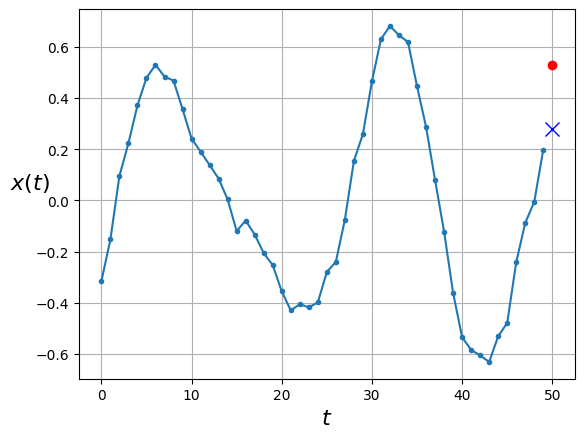

In [ ]:
X_test_tensor = torch.tensor(X_test, device=device)

model_rnn.eval()
with torch.no_grad():
    y_test_pred = model_rnn(X_test_tensor)

y_test_pred = y_test_pred.cpu().numpy()

# Plot prediction
plot_series(X_test[0, :, 0], y_test[0, 0], y_test_pred[0, 0])


### Deep RNN
We can have more than one RNN layers to let the network learn a bit more complex patterns.

For Deep RNN Layers:

num_layers= n tells PyTorch to stack n RNN layers internally.

PyTorch automatically handles passing hidden states between layers.



In [ ]:
# Deep RNN model with multiple RNN layers

class DeepRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=3):
        super(DeepRNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Predict one output

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]   # Take the last output
        out = self.fc(out)
        return out

# Instantiate the model
model_deep_rnn = DeepRNNModel(input_size=1, hidden_size=20, num_layers=3).to(device)


In [ ]:
summary(model_deep_rnn, (50, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 20], [-1, 2, 20]]               0
            Linear-2                    [-1, 1]              21
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_deep_rnn.parameters(), lr=0.001)


In [ ]:
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)

n_epochs = 10
for epoch in range(n_epochs):
    model_deep_rnn.train()
    optimizer.zero_grad()

    y_pred = model_deep_rnn(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


Epoch 1/10, Loss: 0.193263
Epoch 2/10, Loss: 0.174113
Epoch 3/10, Loss: 0.160254
Epoch 4/10, Loss: 0.150583
Epoch 5/10, Loss: 0.144178
Epoch 6/10, Loss: 0.140280
Epoch 7/10, Loss: 0.138183
Epoch 8/10, Loss: 0.137172
Epoch 9/10, Loss: 0.136560
Epoch 10/10, Loss: 0.135786


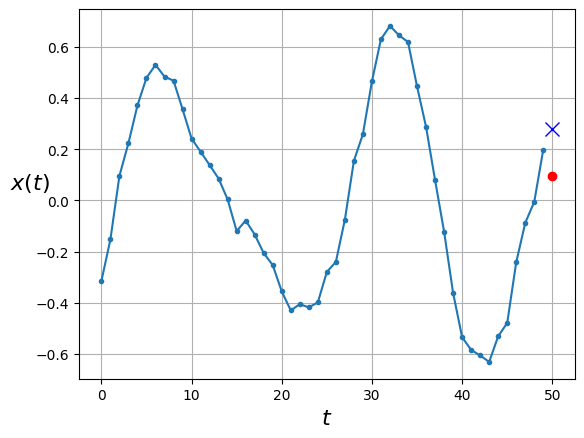

In [ ]:
X_test_tensor = torch.tensor(X_test, device=device)

model_deep_rnn.eval()
with torch.no_grad():
    y_test_pred = model_deep_rnn(X_test_tensor)

y_test_pred = y_test_pred.cpu().numpy()

# Plot prediction
plot_series(X_test[0, :, 0], y_test[0, 0], y_test_pred[0, 0])


### LSTM & GRU:

How LSTM differs from SimpleRNN:

- LSTM has gates (input gate, forget gate, output gate).

- These gates help the model decide what to remember or forget.

- Better for learning long-term dependencies.

- Many deep LSTM models use dropout between layers (we’re keeping it simple here).



In [ ]:
# LSTM model for time series forecasting

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # Take the last output
        out = self.fc(out)
        return out

# Instantiate the model
model_lstm = LSTMModel(input_size=1, hidden_size=20, num_layers=2).to(device)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)


In [ ]:
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)

n_epochs = 10
for epoch in range(n_epochs):
    model_lstm.train()
    optimizer.zero_grad()

    y_pred = model_lstm(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


Epoch 1/10, Loss: 0.149167
Epoch 2/10, Loss: 0.148537
Epoch 3/10, Loss: 0.148049
Epoch 4/10, Loss: 0.147670
Epoch 5/10, Loss: 0.147358
Epoch 6/10, Loss: 0.147066
Epoch 7/10, Loss: 0.146765
Epoch 8/10, Loss: 0.146444
Epoch 9/10, Loss: 0.146106
Epoch 10/10, Loss: 0.145756


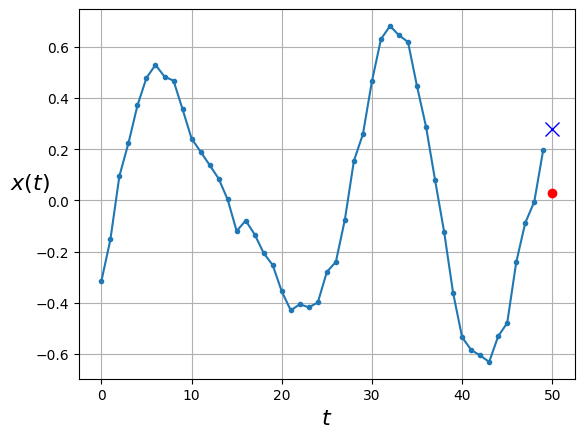

In [ ]:
X_test_tensor = torch.tensor(X_test, device=device)

model_lstm.eval()
with torch.no_grad():
    y_test_pred = model_lstm(X_test_tensor)

y_test_pred = y_test_pred.cpu().numpy()

# Plot prediction
plot_series(X_test[0, :, 0], y_test[0, 0], y_test_pred[0, 0])


In [ ]:
# GRU model for time series forecasting

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Final prediction

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]   # Use last time step output
        out = self.fc(out)
        return out

# Instantiate the model
model_gru = GRUModel(input_size=1, hidden_size=20, num_layers=2).to(device)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)


In [ ]:
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)

n_epochs = 10
for epoch in range(n_epochs):
    model_gru.train()
    optimizer.zero_grad()

    y_pred = model_gru(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


Epoch 1/10, Loss: 0.226748
Epoch 2/10, Loss: 0.213875
Epoch 3/10, Loss: 0.202322
Epoch 4/10, Loss: 0.192036
Epoch 5/10, Loss: 0.182954
Epoch 6/10, Loss: 0.175001
Epoch 7/10, Loss: 0.168100
Epoch 8/10, Loss: 0.162167
Epoch 9/10, Loss: 0.157118
Epoch 10/10, Loss: 0.152868


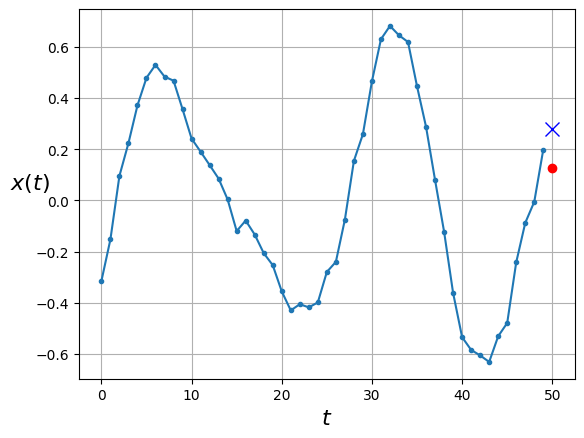

In [ ]:
X_test_tensor = torch.tensor(X_test, device=device)

model_gru.eval()
with torch.no_grad():
    y_test_pred = model_gru(X_test_tensor)

y_test_pred = y_test_pred.cpu().numpy()

# Plot prediction
plot_series(X_test[0, :, 0], y_test[0, 0], y_test_pred[0, 0])


### More than one point?

You can always let model predict more than one point. There can be many ways as follows:
- Let model predict one step ahead and feed it again to the model to predict the next one.
- **Let model predict ten steps all together at the last step.**
- Let model predict ten steps all together at each time step.



In [ ]:
# Regenerate series for multi-step forecasting (predict 10 steps)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

# Split into training, validation, and testing sets
X_train = series[:7000, :n_steps]
Y_train = series[:7000, -10:, 0]   # 10 future steps
X_valid = series[7000:9000, :n_steps]
Y_valid = series[7000:9000, -10:, 0]
X_test = series[9000:, :n_steps]
Y_test = series[9000:, -10:, 0]

# Print shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (7000, 50, 1)
Y_train shape: (7000, 10)
X_valid shape: (2000, 50, 1)
Y_valid shape: (2000, 10)
X_test shape: (1000, 50, 1)
Y_test shape: (1000, 10)


Why predict multiple points at once?
- In real-world forecasting (e.g., weather, finance), predicting just the next point isn’t enough — we need future trajectories.



Note: In the previous parts of this lab we learned a built-in deep RNN, automatically stacking 3 layers internally. In the structure below you can see the manual stacking of two separate RNN layers.

 ```self.rnn1 = nn.RNN(...)```


```self.rnn2 = nn.RNN(...)```

you can use this structure when:

- You need to predict multiple outputs (like forecasting next 10 time steps).

- You want control between layers (e.g., add Dropout, BatchNorm, or attention).

- You want to explore non-uniform RNN configurations.



In [ ]:
# Simple deep RNN model predicting multiple steps (10 outputs)

class MultiStepRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=10):
        super(MultiStepRNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = out[:, -1, :]   # Last time step output
        out = self.fc(out)
        return out

# Instantiate the model
model_multistep = MultiStepRNNModel().to(device)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_multistep.parameters(), lr=0.001)


In [ ]:
X_train_tensor = torch.tensor(X_train, device=device)
Y_train_tensor = torch.tensor(Y_train, device=device)

X_valid_tensor = torch.tensor(X_valid, device=device)
Y_valid_tensor = torch.tensor(Y_valid, device=device)

n_epochs = 100
for epoch in range(n_epochs):
    model_multistep.train()
    optimizer.zero_grad()

    y_pred = model_multistep(X_train_tensor)
    loss = criterion(y_pred, Y_train_tensor)

    loss.backward()
    optimizer.step()

    # Validation
    model_multistep.eval()
    with torch.no_grad():
        val_pred = model_multistep(X_valid_tensor)
        val_loss = criterion(val_pred, Y_valid_tensor)

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")


Epoch 1/100, Train Loss: 0.181810, Val Loss: 0.172918
Epoch 2/100, Train Loss: 0.176603, Val Loss: 0.168404
Epoch 3/100, Train Loss: 0.172025, Val Loss: 0.164425
Epoch 4/100, Train Loss: 0.167982, Val Loss: 0.160908
Epoch 5/100, Train Loss: 0.164401, Val Loss: 0.157791
Epoch 6/100, Train Loss: 0.161221, Val Loss: 0.155019
Epoch 7/100, Train Loss: 0.158385, Val Loss: 0.152546
Epoch 8/100, Train Loss: 0.155849, Val Loss: 0.150334
Epoch 9/100, Train Loss: 0.153573, Val Loss: 0.148352
Epoch 10/100, Train Loss: 0.151528, Val Loss: 0.146574
Epoch 11/100, Train Loss: 0.149685, Val Loss: 0.144976
Epoch 12/100, Train Loss: 0.148024, Val Loss: 0.143538
Epoch 13/100, Train Loss: 0.146523, Val Loss: 0.142243
Epoch 14/100, Train Loss: 0.145164, Val Loss: 0.141074
Epoch 15/100, Train Loss: 0.143932, Val Loss: 0.140014
Epoch 16/100, Train Loss: 0.142810, Val Loss: 0.139046
Epoch 17/100, Train Loss: 0.141782, Val Loss: 0.138155
Epoch 18/100, Train Loss: 0.140831, Val Loss: 0.137322
Epoch 19/100, Train

Plotting:
- We visualize both actual future values and predicted ones over 10 time steps.



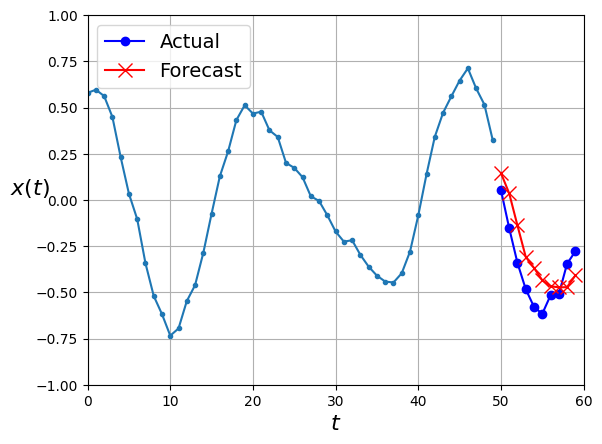

In [ ]:
# Predict on test set
X_test_tensor = torch.tensor(X_test, device=device)

model_multistep.eval()
with torch.no_grad():
    Y_test_pred = model_multistep(X_test_tensor)

Y_test_pred = Y_test_pred.cpu().numpy()

# Helper function to plot forecast
def plot_multiple_forecasts(X, Y, Y_pred, n_steps=50, ahead=10):
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    plt.show()

# Plot first sample
plot_multiple_forecasts(X_test, Y_test, Y_test_pred)


## Time Series Forecasting: Stock Price Prediction
The task at hand is a classic example of time series forecasting, where the goal is to predict future values based on previously observed values. Specifically, we aim to predict the future stock prices of Apple Inc. (AAPL) using historical stock price data.

The primary goal is to develop a predictive model that can accurately forecast future stock prices. By analyzing patterns and trends in historical data, the model will attempt to predict the closing prices of the stock for the upcoming days.

## Challenges in Time Series Forecasting
- **Temporal Dependency**: Unlike traditional regression tasks, time series data points are dependent on each other over time. Capturing this temporal dependency is crucial for accurate predictions.
- **Trend and Seasonality**: Stock prices often exhibit trends (long-term increase or decrease) and seasonality (repeating patterns over specific periods). Identifying and modeling these components is essential.
- **Noise and Volatility**: Financial data is typically noisy and can be highly volatile due to market conditions, economic events, and other external factors.
- **Data Stationarity**: Many statistical models assume that the time series data is stationary, meaning its statistical properties do not change over time. Non-stationary data needs to be transformed for effective modeling.


## Installing yfinance
This cell installs the yfinance library, which is used to download historical market data from Yahoo Finance. This library will be used later to fetch stock prices.



In [ ]:
!pip install yfinance

## Loading and Preparing the Dataset
When we run the first line, the library fetches the historical stock data for Apple Inc. (AAPL) from Yahoo Finance for the date range specified, which is from January 1, 2010, to January 1, 2021. This data includes various columns such as 'Open', 'High', 'Low', 'Close', 'Volume', and 'Adj Close'. The data is returned as a Pandas DataFrame. The closing prices are extracted from the DataFrame and converted to a NumPy array of floats for numerical computations. Next, the data is normalized to the range [-1, 1] using MinMaxScaler, which helps in improving the performance and convergence rate of the neural network.

In [ ]:
# Download historical stock data for Apple (AAPL)
df = yf.download('AAPL', start='2010-01-01', end='2021-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Focus only on closing prices
data = df['Close'].values.astype(float)

In [ ]:
# Define sequence length for time series sequences
seq_length = 30

# Split into training and test sets (80/20)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

Beware of data leakage when splitting/normalizing time series!

In [ ]:
# Normalize data separately to avoid data leakage
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

Important Note:

- Financial forecasting is often non-stationary and stock prices have heavy tails.

- Stock prices are extremely hard to predict and models usually predict returns, not prices, in real finance

## Creating Sequences for Training
The function create_sequences is defined to generate sequences of length 30 from the normalized data, where each sequence is used to predict the next value. The data is then split into training and testing sets, with 80% used for training and 20% for testing. Finally, the training and testing data are converted to PyTorch tensors, making them ready for model training and evaluation. This comprehensive preprocessing ensures that the data is appropriately formatted and scaled for the GRU model.

In [ ]:
# Function to create sequences and targets from data
def create_sequences(data, seq_length):
  # Initialize a list to store input sequences
  xs = []
  # Initialize a list to store target values
  ys = []
  for i in range(len(data) - seq_length):
    # Extract a sequence of length seq_length
    x = data[i:i+seq_length]
    # Extract the next data point
    y = data[i+seq_length]
    # Append the sequence to the input list
    xs.append(x)
    # Append the target value to the target list
    ys.append(y)
  return np.array(xs), np.array(ys)


In [ ]:
# Create sequences
X_train, y_train = create_sequences(train_data_normalized, seq_length)
X_test, y_test = create_sequences(test_data_normalized, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

### Create DataLoaders for Efficient Training

In [ ]:
# Create datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining the GRU Model
In this cell, we define the architecture of the GRU (Gated Recurrent Unit) model using PyTorch's nn.Module. The GRUModel class is created, and the __init__ method initializes the parameters of the model, including input_size, hidden_size, output_size, and num_layers. The GRU layer is defined with the specified input size, hidden size, and number of layers. Additionally, a fully connected layer (nn.Linear) is added to map the GRU outputs to the desired output size. The forward method defines the forward pass of the model, where an initial hidden state is created, the input data is passed through the GRU layer, and the output of the last time step is passed through the fully connected layer to generate the final prediction. This model architecture is designed to capture temporal dependencies in the stock price data, making it well-suited for time series forecasting.


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.2):
        super(GRUModel, self).__init__()
        # Define the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        # Define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size, device=x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Only use the last time step output
        return out


## Initializing the Model, Loss Function, and Optimizer
In this cell, we initialize the GRU model with specific hyperparameters. The input_size is set to 1, as we are using a single feature (the closing price). The hidden_size is set to 100, indicating the number of features in the hidden state. The output_size is set to 1, as we are predicting a single value (the next closing price). The num_layers is set to 2, indicating that the GRU will have two stacked layers. Dropout rate is set to 0.2 to prevent the model from overfitting.

The mean squared error (MSELoss) is chosen as the loss function, which measures the average squared difference between the predicted and actual values. The Adam optimizer is initialized with a learning rate of 0.001, which will be used to update the model parameters during training. This setup prepares the model for the training process, defining how it will learn from the data.

In [ ]:
# Initialize model with hyperparameters
model = GRUModel(input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout_prob=0.2)

# Define Mean Squared Error loss
loss_function = nn.MSELoss()

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the model
This cell handles the training process of the GRU model. The model is trained for a specified number of epochs (num_epochs set to 50). For each epoch, the model is set to training mode using model.train(). The training data is loaded in batches using train_loader. For each batch, the optimizer gradients are zeroed, the model makes predictions, the loss is computed, and the loss is backpropagated. The optimizer then updates the model parameters. After each epoch, the model is set to evaluation mode using model.eval(), and the validation loss is computed using val_loader. This validation step ensures that the model's performance is monitored on unseen data, helping to prevent overfitting. The average validation loss is printed at the end of each epoch, providing insight into the model's progress and effectiveness.

Then, The model is set to evaluation mode using model.eval() to ensure that it does not update its parameters during testing. The evaluation is done within a torch.no_grad() context to prevent gradient computation, making the process faster and more memory-efficient. The test data is loaded in batches using test_loader. For each batch, the model makes predictions, and the loss is computed using the mean squared error criterion. The cumulative test loss is computed by summing the loss for each batch. Finally, the average test loss is printed, providing an unbiased estimate of the model's performance on unseen data. This step is crucial to verify that the model generalizes well and is ready for real-world predictions.

In [ ]:
# Number of training epochs
epochs = 50

# For tracking losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for seqs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for seqs, labels in test_loader:
            outputs = model(seqs)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()

    # Record losses
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))

    if epoch % 10 == 0:
        print(f'Epoch {epoch:3}: Train Loss = {running_loss / len(train_loader):.6f}, Test Loss = {test_loss / len(test_loader):.6f}')


Epoch   0: Train Loss = 0.032689, Test Loss = 0.369181
Epoch  10: Train Loss = 0.000779, Test Loss = 0.192085
Epoch  20: Train Loss = 0.000833, Test Loss = 0.211603
Epoch  30: Train Loss = 0.000638, Test Loss = 0.261252
Epoch  40: Train Loss = 0.000495, Test Loss = 0.322951


## Making Predictions
In this cell, we demonstrate how to use the trained GRU model to make predictions on new data. The model is set to evaluation mode using model.eval(), ensuring that no gradients are computed, and the model's parameters remain unchanged. Within a torch.no_grad() context, a sample input data is converted to a PyTorch tensor. The model then makes predictions based on this input data. The predicted values are printed, showcasing the model's ability to forecast future stock prices. This step illustrates the practical application of the trained model, allowing us to make informed predictions based on historical data.

In [ ]:
# Switch to evaluation mode
model.eval()

# Function to generate predictions
def predict(model, loader):
    preds = []
    with torch.no_grad():
        for seqs, _ in loader:
            outputs = model(seqs)
            preds.extend(outputs.squeeze().cpu().numpy())
    return np.array(preds)


In [ ]:
# Create a train eval loader without shuffle
train_eval_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Generate predictions
train_predictions = predict(model, train_eval_loader)
test_predictions = predict(model, test_loader)

# Inverse transform predictions and true values
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


### Plot Predictions vs True Values

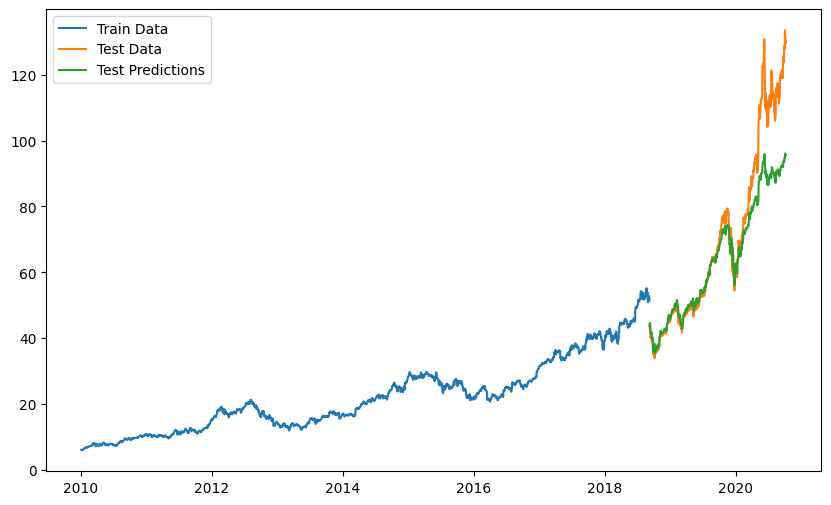

In [ ]:
plt.figure(figsize=(10,6))

# Plot the actual training data
plt.plot(df.index[:len(y_train)], y_train, label='Train Data')
# Plot the actual test data
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Test Data')
# Plot the model's predictions for the test data
plt.plot(df.index[len(train_predictions):len(train_predictions)+len(test_predictions)],
         test_predictions, label='Test Predictions')

plt.legend()
plt.show()

## Task 1

In the lab, we implemented some simple RNNs.  In this task implement a MultiStepRNNModel class that builds a recurrent neural network with the following architecture:

- An RNN layer with the input size set to 1, hidden_size=20, and batch_first=True.

- A second RNN layer with the input size set to 1, hidden_size=20, and batch_first=True.

- A BatchNorm1d layer applied to the output of the final RNN layer at the last time step (the output should have 20 features).

- A Dropout layer with the dropout ratio set by the dropout_prob parameter.

- A final linear output layer that maps 20 features to 10 outputs.

In [ ]:
class MultiStepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=10, dropout_prob=0.3):
        # continue
        super(MultiStepRNN, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # continue
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out


NameError: name 'nn' is not defined

---

*End of Task 1. Copy your final code to **Homework 4 - Code** on **NextIlearn***

## Task 2

Previously, you have learned to build CNNs and MLPs from scratch.
Now, you will apply your knowledge to create a model and fine-tune it on a real dataset!

You have already recieved a folder `data` with this notebook. In this directory, you can find a `./data/Task2` directory. The `train` directory includes 5400 images, you can also find a file called `train_labels.csv` which includes the labels of you image train dataset. You can also find the `test` folder including 600 images as your test set.

In this task, you will:

Train CNN model on the provided dataset (either from scratch or using a pretrained model) on the training set provided.

Predict the labels for test set of images provided in `test`.

Save your predictions to a file `submission.csv`. Ensure your file is named `submission.csv` and includes a column titled `predictions`.

You can design any CNN model from scratch or use any pretrained model (e.g., ResNet, VGG, DenseNet) from ```torchvision.models```.

Your model must achieve at least 65% test accuracy on the test predictions to pass.

In [17]:
import numpy as np
import pandas as pd

# load training data:
data_train   = np.load('/content/Lab4/train_data.npy')
labels_train = np.load('/content/Lab4/train_labels.npy')

In [18]:
# labels:
np.unique(labels_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

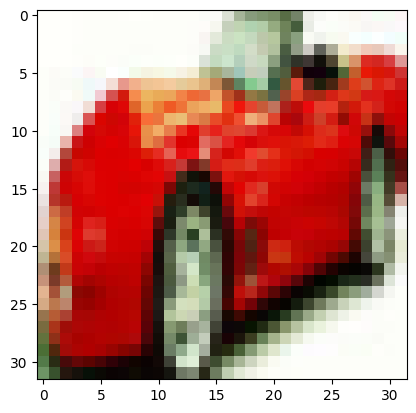

In [19]:
# data:
import matplotlib.pyplot as plt
i = np.random.randint(0, len(data_train))
plt.imshow(data_train[i].reshape(3, 32, 32).transpose(1, 2, 0))
plt.show()

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np

#Load and modify resnet18

model= torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate = 0.001
criterion = nn.CrossEntropyLoss() # setting up the loss function

# Reshape the data if only 2 dimensions and if it is flat:
if data_train.ndim == 2 and data_train.shape[1] == 3072:
    data_train = data_train.reshape(-1, 3, 32, 32) # 32x32 pixels

# Convert NumPy to PyTorch Tensors
tensor_x = torch.tensor(data_train, dtype=torch.float32)
tensor_y = torch.tensor(labels_train, dtype=torch.long)

# Create a TensorDataset
train_dataset = TensorDataset(tensor_x, tensor_y)

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Training Loop (5 epochs)
for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad() # clears old gradients from previous step
        loss = criterion(model(inputs), labels) # forward pass: compute predictions and loss
        loss.backward() # backward pass: compute gradients via backpropagation
        optimizer.step() # update weights using gradients
        total_loss += loss.item() # adds current batch loss to epoch total
    print(f"Epoch {epoch+1}/5, Loss: {total_loss/len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 1.4499
Epoch 2/5, Loss: 1.0659
Epoch 3/5, Loss: 0.8818
Epoch 4/5, Loss: 0.7153
Epoch 5/5, Loss: 0.5967


In [22]:


data_test = np.load('/content/Lab4/test_data.npy')

# reshape if flattened:
if data_test.ndim == 2 and data_test.shape[1] == 3072:
  data_test = data_test.reshape(-1, 3, 32, 32)

# convert and wrap data
tensor_test = torch.tensor(data_test, dtype=torch.float32)
test_dataset = TensorDataset(tensor_test)
loader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

# run model in evaluation mode
model.eval()
predictions = []

# inference without gradient tracking:
with torch.no_grad():
  for batch in loader_test:
    inputs = batch[0].to(device)
    outputs = model(inputs) # get raw output scores for each class
    preds = torch.argmax(outputs, dim=1) # takes the class label of the highest scoring output
    predictions.extend(preds.cpu().numpy())

pd.DataFrame(predictions, columns=['prediction']).to_csv('submission.csv')

---

*End of Task 2. Upload your final predictions (the file* `submission.csv` *) to **Homework 4 - Code** on **NextIlearn***